# Image Classifier with Pretrained Model

# 1. Import libraries

In [ ]:
%cd transformer-for-image-classification
!pip install torchinfo

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
import requests
from torchvision import transforms

from modules.data_prep import create_dataloaders
from modules.evaluation import show_losses_and_accs
from modules.prediction import pred_and_plot_image
from modules.others import plot_an_image
from modules.others import set_seeds, save_model
from modules.train_prep import train

from torchinfo import summary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Load dataset
!unzip data/flower_photos.zip -d data/

# 2. Create DataLoaders

In [ ]:
# Setup parameters to train and test images
path = "data/flower_photos"
IMG_SIZE = 224 # image siz
BATCH_SIZE = 32 # batch size

# Create transform pipeline manually
image_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(root_path=path, transform=image_transforms, batch_size=BATCH_SIZE)

print(f"Manually created transforms: {image_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


# 3. Preprocess and plot an image

Patch + token + position embeddings: torch.Size([1, 197, 768])


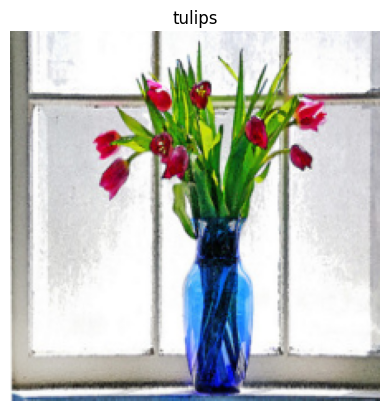

In [ ]:
# Set seeds
set_seeds()

# Set image patch size
patch_size = 16

# Visualize a image
plot_an_image(train_dataloader, class_names, patch_size)

# 4. Get the model

In [ ]:
set_seeds()
# 1. Get pretrained weights
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup the model with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 68.7MB/s]


In [ ]:
summary(model=pretrained_vit, input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 5]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

# 5. Train the model

In [ ]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                               optimizer=optimizer, loss_fn=loss_fn, epochs=10, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7134 | train_acc: 0.7714 | test_loss: 0.4578 | test_acc: 0.8802
Epoch: 2 | train_loss: 0.3616 | train_acc: 0.8928 | test_loss: 0.3658 | test_acc: 0.8870
Epoch: 3 | train_loss: 0.2809 | train_acc: 0.9194 | test_loss: 0.3303 | test_acc: 0.9034
Epoch: 4 | train_loss: 0.2378 | train_acc: 0.9384 | test_loss: 0.2926 | test_acc: 0.9116
Epoch: 5 | train_loss: 0.2078 | train_acc: 0.9438 | test_loss: 0.2712 | test_acc: 0.9142
Epoch: 6 | train_loss: 0.1838 | train_acc: 0.9509 | test_loss: 0.2759 | test_acc: 0.9157
Epoch: 7 | train_loss: 0.1674 | train_acc: 0.9598 | test_loss: 0.2548 | test_acc: 0.9156
Epoch: 8 | train_loss: 0.1526 | train_acc: 0.9630 | test_loss: 0.2505 | test_acc: 0.9292
Epoch: 9 | train_loss: 0.1420 | train_acc: 0.9689 | test_loss: 0.2486 | test_acc: 0.9224
Epoch: 10 | train_loss: 0.1307 | train_acc: 0.9727 | test_loss: 0.2414 | test_acc: 0.9210


In [ ]:
# Save the model
save_model(model=pretrained_vit, target_dir="models", model_name="img_classifier_with_pretrained_model.pth")

[INFO] Saving model to: models/img_classifier_with_pretrained_model.pth


# 6. Evaluation

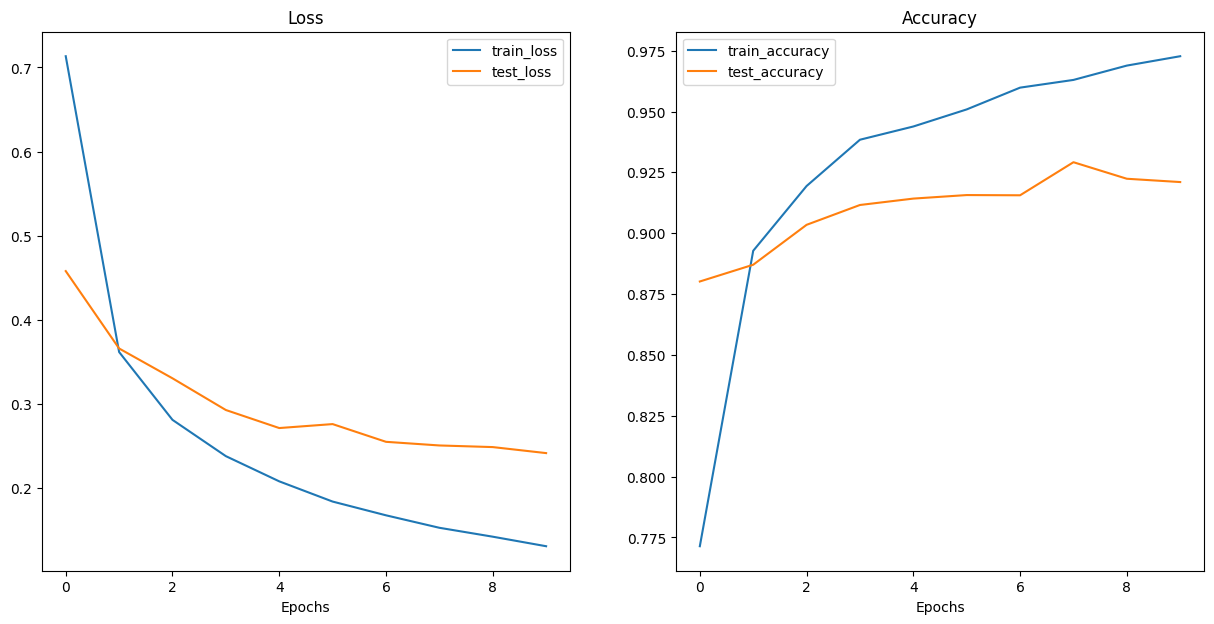

In [ ]:
# Plot the losses and accs
show_losses_and_accs(pretrained_vit_results)

# 7. Predict the results

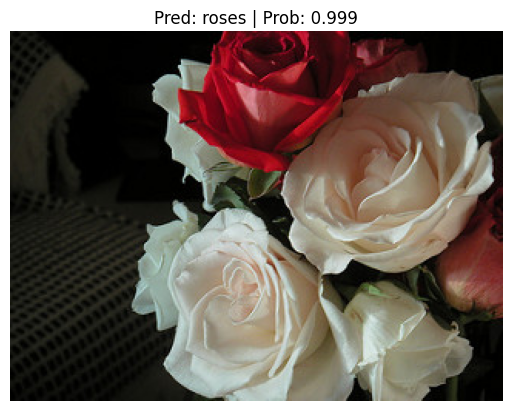

In [ ]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup an mage path
image_path = path + "/roses/102501987_3cdb8e5394_n.jpg"
pred_and_plot_image(model=pretrained_vit, image_path=image_path, class_names=class_names)

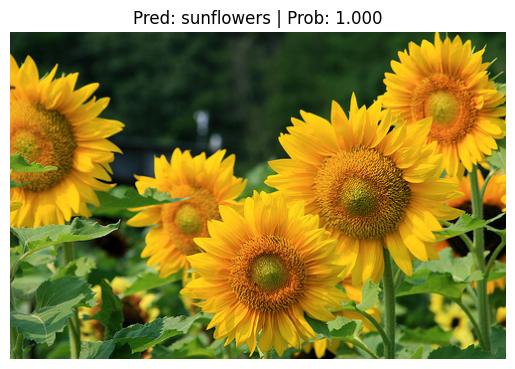

In [ ]:
# Setup an image path
image_path_1 = image_path = path + "/sunflowers/1008566138_6927679c8a.jpg"
pred_and_plot_image(model=pretrained_vit, image_path=image_path_1, class_names=class_names)